Query Twitter API for topic of choice, returns user, date, country and text

In [ ]:
#
#Adopted from https://stackabuse.com/accessing-the-twitter-api-with-python/
#
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tweepy as tw
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx

import json
import twython
from twython import Twython
import pandas as pd

import sys,csv
from textblob import TextBlob

credentials = {}
credentials['CONSUMER_KEY'] = "UgNavLjPTebpBYVkDh960JKt0"
credentials['CONSUMER_SECRET'] = "VqjdK5m1zZvie2B57Gnfh1EGiGEmg7CJKMuakjBWqTGg7YavKS"
credentials['ACCESS_TOKEN'] = "1101959314644893702-zuKzbXoAvi5nyVW0Vc0v5NbT2NUZPY"
credentials['ACCESS_SECRET'] = "m1IXH2wQU53drnhCuoOklLhBwKMq4ayAWHlkwA3EUgygP"


with open("twitter_credentials.json", "w") as file:
    json.dump(credentials, file)
    
with open("twitter_credentials.json", "r") as file:
    creds = json.load(file)

python_tweets = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])

searchTerm='Myanmar,Burma,myanmar,burma -filter:retweets'


query = {'q': searchTerm,
        'result_type': 'recent',
        'count': 1000,
        'lang': 'en',
}



dict_ = {'user': [], 'date': [], 'text': [], 'country': []}
for status in  python_tweets.search(**query)['statuses']:
    dict_['user'].append(status['user']['screen_name'])
    dict_['date'].append(status['created_at'])
    dict_['text'].append(status['text'])
    dict_['country'].append(status['user']['location'])


df = pd.DataFrame(dict_)
df.sort_values(by='date', inplace=True, ascending=False)
df['text'] = df['text'].str.replace('[#,@,&]', '') 

df.head(100)

,user,date,text,country
0,shiftychicken,Thu Mar 18 18:12:26 +0000 2021,BBGRichie In other news....https://t.co/x2kr5A...,"Oswestry, UK"
1,Thae_Thae_,Thu Mar 18 18:11:20 +0000 2021,Burma has been turned into a slaughter ground(...,
2,PlanBurma,Thu Mar 18 18:09:53 +0000 2021,20210318 ​ရေစကြို Yesagyo\nNever fails a day!\...,Myanmar
3,Hoppiebangtan94,Thu Mar 18 18:07:14 +0000 2021,TostevinM aapp_burma Remember MYANMAR IS NOT S...,United States
4,PlanBurma,Thu Mar 18 18:06:45 +0000 2021,20210318 ပြည် Pyay\nNever fails a day!\nHit th...,Myanmar
...,...,...,...,...
95,news_burma,Thu Mar 18 16:05:53 +0000 2021,Detained at night lifeless by morning: Arrests...,
96,news_burma,Thu Mar 18 16:04:35 +0000 2021,Myanmar: internet cutoff looms as junta flexes...,
97,news_burma,Thu Mar 18 16:04:06 +0000 2021,MBtv: 'My awakening moment' - Myanmar soldier ...,
98,knoe_khin,Thu Mar 18 16:03:24 +0000 2021,Myanmar military killed Burma people amp; citi...,United States


Initial preprocessing 

In [ ]:
#Preprocessing
from nltk.corpus import stopwords

stop = stopwords.words('english')
tdf = df['text']

df_ww = pd.DataFrame(tdf)
df_ww.columns = ["tweet"]

stop_words = set(stopwords.words('english'))
collection_words = ['burma', 'myanmar','Myanmar','Burma','RT','MYANMAR','BURMA']

# Tweets w/o collection words
df_ww['tweet_cw'] = df_ww['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (collection_words)]))
# Tweets w/o stop words
df_ww['tweet_wsw'] = df_ww['tweet_cw'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_ww.head(50)

,tweet,tweet_cw,tweet_wsw
0,Terrorist junta besieging amp; massacre.\nPlea...,Terrorist junta besieging amp; massacre. Pleas...,Terrorist junta besieging amp; massacre. Pleas...
1,MayWongCNA Would u please tell MAL that no one...,MayWongCNA Would u please tell MAL that no one...,MayWongCNA Would u please tell MAL one welcome...
2,Heightened repression violent resistance agoni...,Heightened repression violent resistance agoni...,Heightened repression violent resistance agoni...
3,Burma has been turned into a slaughter ground(...,has been turned into a slaughter ground(not a ...,turned slaughter ground(not war zone battle gr...
4,CIJ_ICJ SaveMyanmar \nWe need R2P in Myanmar B...,CIJ_ICJ SaveMyanmar We need R2P in https://t.c...,CIJ_ICJ SaveMyanmar We need R2P https://t.co/q...
5,News from Myanmar | Around 547 out of a total ...,News from | Around 547 out of a total of 770 s...,News | Around 547 total 770 students arrested ...
6,UN_HRC SaveMyanmar \nWe need R2P in Myanmar Bu...,UN_HRC SaveMyanmar We need R2P in https://t.co...,UN_HRC SaveMyanmar We need R2P https://t.co/QW...
7,Almost 550 Student Protesters Still Being Deta...,Almost 550 Student Protesters Still Being Deta...,Almost 550 Student Protesters Still Being Deta...
8,In the world \nThere are expectant mothers in ...,In the world There are expectant mothers in Bu...,In world There expectant mothers Burma(Myanmar...
9,INTERNET BLACKOUT\nBurma (Myanmar) military ju...,INTERNET BLACKOUT (Myanmar) military juntas cu...,INTERNET BLACKOUT (Myanmar) military juntas cu...


In [ ]:
#Remove duplicates

In [ ]:
df = pd.DataFrame(df_ww)
df= df.drop_duplicates()

In [ ]:
df['clean']= df['tweet_wsw'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df=df['clean']
df.columns = ["text"]
df.head(10)

0    Terrorist junta besieging amp; massacre. Pleas...
1    MayWongCNA Would u please tell MAL one welcome...
2    Heightened repression violent resistance agoni...
3    turned slaughter ground(not war zone battle gr...
4                     CIJ_ICJ SaveMyanmar We need R2P 
5    News | Around 547 total 770 students arrested ...
6                      UN_HRC SaveMyanmar We need R2P 
7    Almost 550 Student Protesters Still Being Deta...
8    In world There expectant mothers Burma(Myanmar...
9    INTERNET BLACKOUT (Myanmar) military juntas cu...
Name: clean, dtype: object

In [ ]:
df.columns = ["text"]
df.to_csv('clean_tweets.csv')

In [ ]:
import pandas as pd 
import numpy as np
data = df

Use TF-IDF for removing high TF-IDF words not relevent to analysis

In [ ]:
import math
from textblob import TextBlob as tb #text processing library

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

bloblist = list(map(tb, data))
for i, blob in enumerate(bloblist):
    print("Top words in tweet {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:3]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))
    if i == 10:
        break

Top words in tweet 1
	Word: please, TF-IDF: 0.43032
	Word: Please, TF-IDF: 0.3313
	Word: besieging, TF-IDF: 0.24412
Top words in tweet 2
	Word: Would, TF-IDF: 0.24412
	Word: u, TF-IDF: 0.24412
	Word: tell, TF-IDF: 0.24412
Top words in tweet 3
	Word: Heightened, TF-IDF: 0.3107
	Word: repression, TF-IDF: 0.3107
	Word: violent, TF-IDF: 0.3107
Top words in tweet 4
	Word: ground.Military, TF-IDF: 0.3107
	Word: police, TF-IDF: 0.3107
	Word: slaughtered, TF-IDF: 0.3107
Top words in tweet 5
	Word: CIJ_ICJ, TF-IDF: 0.68355
	Word: SaveMyanmar, TF-IDF: 0.60245
	Word: We, TF-IDF: 0.54492
Top words in tweet 6
	Word: Around, TF-IDF: 0.24412
	Word: 547, TF-IDF: 0.24412
	Word: 770, TF-IDF: 0.24412
Top words in tweet 7
	Word: SaveMyanmar, TF-IDF: 0.60245
	Word: UN_HRC, TF-IDF: 0.54492
	Word: We, TF-IDF: 0.54492
Top words in tweet 8
	Word: Almost, TF-IDF: 0.28481
	Word: 550, TF-IDF: 0.28481
	Word: Student, TF-IDF: 0.28481
Top words in tweet 9
	Word: In, TF-IDF: 0.2629
	Word: expectant, TF-IDF: 0.2629
	W

In [ ]:
import gensim
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

def read_data(data_file):
    for i, line in enumerate (data_file): 
        yield gensim.utils.simple_preprocess (line)
        
dataset = list(read_data(data))
dct = Dictionary(dataset)
corpus = [dct.doc2bow(line) for line in dataset]
model = TfidfModel(corpus)
vector = model[corpus[0]]

for i in range(len(vector)):
    print("{!s:.5}\t{}".format(vector[i][1], dataset[0][i]))

0.307	terrorist
0.307	junta
0.225	besieging
0.307	amp
0.173	massacre
0.307	please
0.151	save
0.346	unarmed
0.307	civilians
0.307	un_hrc
0.255	please
0.225	help
0.307	protect


In [ ]:
np.savetxt('mm_tweets.txt', data, fmt = "%s") 

In [ ]:
import collections

def generate_zipf_table(text,top):
    text = _remove_punctuation(text)
    text = text.lower()
    top_word_frequencies = _top_word_frequencies(text, top)
    zipf_table = _create_zipf_table(top_word_frequencies)
    return zipf_table

def _remove_punctuation(text):
    chars_to_remove = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789"
    tr = str.maketrans("", "", chars_to_remove)
    return text.translate(tr)

def _top_word_frequencies(text, top):
    words = text.split()
    word_frequencies = collections.Counter(words)
    top_word_frequencies = word_frequencies.most_common(top)
    return top_word_frequencies

def _create_zipf_table(frequencies):
    zipf_table = []
    top_frequency = frequencies[0][1]
    for index, item in enumerate(frequencies, start=1):
        relative_frequency = "1/{}".format(index)
        zipf_frequency = top_frequency * (1 / index)
        difference_actual = item[1] - zipf_frequency
        difference_percent = (item[1] / zipf_frequency) * 100
        zipf_table.append({"word": item[0],
                           "actual_frequency": item[1],
                           "relative_frequency": relative_frequency,
                           "zipf_frequency": zipf_frequency,
                           "difference_actual": difference_actual,
                           "difference_percent": difference_percent})

    return zipf_table


def print_zipf_table(zipf_table):
    width = 80
    print("-" * width)
    print("|Rank|    Word    |Actual Freq | Zipf Frac  | Zipf Freq  |Actual Diff |Pct Diff|")
    print("-" * width)
    format_string = "|{:4}|{:12}|{:12.0f}|{:>12}|{:12.2f}|{:12.2f}|{:7.2f}%|"
    for index, item in enumerate(zipf_table, start=1):
        print(format_string.format(index,
                                   item["word"],
                                   item["actual_frequency"],
                                   item["relative_frequency"],
                                   item["zipf_frequency"],
                                   item["difference_actual"],
                                   item["difference_percent"]))

    print("-" * width)
if __name__== "__main__": 
        f = open("mm_tweets.txt", "r")
        text = f.read()
        f.close()
        zipf_table = generate_zipf_table(text,100)
        print_zipf_table(zipf_table)


--------------------------------------------------------------------------------
|Rank|    Word    |Actual Freq | Zipf Frac  | Zipf Freq  |Actual Diff |Pct Diff|
--------------------------------------------------------------------------------
|   1|military    |          17|         1/1|       17.00|        0.00| 100.00%|
|   2|the         |          14|         1/2|        8.50|        5.50| 164.71%|
|   3|yangon      |          14|         1/3|        5.67|        8.33| 247.06%|
|   4|turned      |           9|         1/4|        4.25|        4.75| 211.76%|
|   5|war         |           9|         1/5|        3.40|        5.60| 264.71%|
|   6|zone        |           9|         1/6|        2.83|        6.17| 317.65%|
|   7|today       |           9|         1/7|        2.43|        6.57| 370.59%|
|   8|aka         |           8|         1/8|        2.12|        5.88| 376.47%|
|   9|people      |           8|         1/9|        1.89|        6.11| 423.53%|
|  10|please      |         

Add irrelevant words to be removed in preprocessing cell (above)

How people are reacting on Myanmar,Burma,myanmar,burma -filter:retweets by analyzing 1000 tweets.

General Report: 
Weakly Negative

Detailed Report: 
4.80% people thought it was positive
13.70% people thought it was weakly positive
1.30% people thought it was strongly positive
6.40% people thought it was negative
31.00% people thought it was weakly negative
1.40% people thought it was strongly negative
41.30% people thought it was neutral


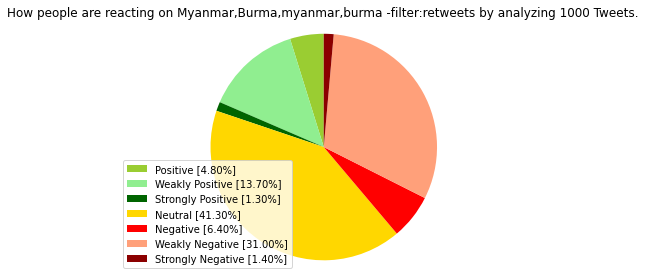

In [ ]:
"""
Adapted from: https://github.com/the-javapocalypse/Twitter-Sentiment-Analysis/blob/master/main.py
"""
class SentimentAnalysis:

    def __init__(self):
        self.tweets = []
        self.tweetText = []

    def DownloadData(self):
        # authenticating
        consumerKey = "UgNavLjPTebpBYVkDh960JKt0"
        consumerSecret = "VqjdK5m1zZvie2B57Gnfh1EGiGEmg7CJKMuakjBWqTGg7YavKS"
        accessToken = "1101959314644893702-zuKzbXoAvi5nyVW0Vc0v5NbT2NUZPY"
        accessTokenSecret = "m1IXH2wQU53drnhCuoOklLhBwKMq4ayAWHlkwA3EUgygP"
        auth = tw.OAuthHandler(consumerKey, consumerSecret)
        auth.set_access_token(accessToken, accessTokenSecret)
        api = tw.API(auth)


        searchTerm = 'Myanmar,Burma,myanmar,burma -filter:retweets'
        NoOfTerms = 1000


        self.tweets = tw.Cursor(api.search, q=searchTerm, lang = "en").items(NoOfTerms)


        csvFile = open('result.csv', 'a')

        # Use csv writer
        csvWriter = csv.writer(csvFile)



        polarity = 0
        positive = 0
        wpositive = 0
        spositive = 0
        negative = 0
        wnegative = 0
        snegative = 0
        neutral = 0


        for tweet in self.tweets:
            #Append to temp so that we can store in csv later. I use encode UTF-8
            self.tweetText.append(self.cleanTweet(tweet.text).encode('utf-8'))
            # print (tweet.text.translate(non_bmp_map))    #print tweet's text
            analysis = TextBlob(tweet.text)
            # print(analysis.sentiment)  # print tweet's polarity
            polarity += analysis.sentiment.polarity  # adding up polarities to find the average later

            if (analysis.sentiment.polarity == 0):  # adding reaction of how people are reacting to find average later
                neutral += 1
            elif (analysis.sentiment.polarity > 0 and analysis.sentiment.polarity <= 0.3):
                wpositive += 1
            elif (analysis.sentiment.polarity > 0.3 and analysis.sentiment.polarity <= 0.6):
                positive += 1
            elif (analysis.sentiment.polarity > 0.6 and analysis.sentiment.polarity <= 1):
                spositive += 1
            elif (analysis.sentiment.polarity > -0.3 and analysis.sentiment.polarity <= 0):
                wnegative += 1
            elif (analysis.sentiment.polarity > -0.6 and analysis.sentiment.polarity <= -0.3):
                negative += 1
            elif (analysis.sentiment.polarity > -1 and analysis.sentiment.polarity <= -0.6):
                snegative += 1



        csvWriter.writerow(self.tweetText)
        csvFile.close()


        positive = self.percentage(positive, NoOfTerms)
        wpositive = self.percentage(wpositive, NoOfTerms)
        spositive = self.percentage(spositive, NoOfTerms)
        negative = self.percentage(negative, NoOfTerms)
        wnegative = self.percentage(wnegative, NoOfTerms)
        snegative = self.percentage(snegative, NoOfTerms)
        neutral = self.percentage(neutral, NoOfTerms)


        polarity = polarity / NoOfTerms


        print("How people are reacting on " + searchTerm + " by analyzing " + str(NoOfTerms) + " tweets.")
        print()
        print("General Report: ")

        if (polarity == 0):
            print("Neutral")
        elif (polarity > 0 and polarity <= 0.3):
            print("Weakly Positive")
        elif (polarity > 0.3 and polarity <= 0.6):
            print("Positive")
        elif (polarity > 0.6 and polarity <= 1):
            print("Strongly Positive")
        elif (polarity > -0.3 and polarity <= 0):
            print("Weakly Negative")
        elif (polarity > -0.6 and polarity <= -0.3):
            print("Negative")
        elif (polarity > -1 and polarity <= -0.6):
            print("Strongly Negative")

        print()
        print("Detailed Report: ")
        print(str(positive) + "% people thought it was positive")
        print(str(wpositive) + "% people thought it was weakly positive")
        print(str(spositive) + "% people thought it was strongly positive")
        print(str(negative) + "% people thought it was negative")
        print(str(wnegative) + "% people thought it was weakly negative")
        print(str(snegative) + "% people thought it was strongly negative")
        print(str(neutral) + "% people thought it was neutral")

        self.plotPieChart(positive, wpositive, spositive, negative, wnegative, snegative, neutral, searchTerm, NoOfTerms)


    def cleanTweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w +:\ / \ / \S +)", " ", tweet).split())

    def percentage(self, part, whole):
        temp = 100 * float(part) / float(whole)
        return format(temp, '.2f')

    def plotPieChart(self, positive, wpositive, spositive, negative, wnegative, snegative, neutral, searchTerm, noOfSearchTerms):
        labels = ['Positive [' + str(positive) + '%]', 'Weakly Positive [' + str(wpositive) + '%]','Strongly Positive [' + str(spositive) + '%]', 'Neutral [' + str(neutral) + '%]',
                  'Negative [' + str(negative) + '%]', 'Weakly Negative [' + str(wnegative) + '%]', 'Strongly Negative [' + str(snegative) + '%]']
        sizes = [positive, wpositive, spositive, neutral, negative, wnegative, snegative]
        colors = ['yellowgreen','lightgreen','darkgreen', 'gold', 'red','lightsalmon','darkred']
        patches, texts = plt.pie(sizes, colors=colors, startangle=90)
        plt.legend(patches, labels, loc="best")
        plt.title('How people are reacting on ' + searchTerm + ' by analyzing ' + str(noOfSearchTerms) + ' Tweets.')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()



if __name__== "__main__":
    sa = SentimentAnalysis()
    sa.DownloadData()